In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
from numpy.lib.function_base import append
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump, load
import json
import pandas as pd
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_mean = torch.load('./drive/MyDrive/ECE9039-Project/Code/ConvNext/Retrained/normalizer_mean.pt')
train_std = torch.load('./drive/MyDrive/ECE9039-Project/Code/ConvNext/Retrained/normalizer_std.pt')

In [5]:

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

In [6]:
image_datasets = torchvision.datasets.ImageFolder(root= "./drive/MyDrive/ECE9039-Project/Generalization_Images", transform=test_transform)
gen_loader = torch.utils.data.DataLoader(image_datasets, batch_size=1, shuffle=True, num_workers=2)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2)

Files already downloaded and verified


In [7]:
# Device configuration
device = torch.device('cuda')
classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

In [8]:
model = torch.load("./drive/MyDrive/ECE9039-Project/Code/ConvNext/Model_ConvNeXt_Pretrained_Modified_10E")

In [15]:
xgen = []
ygen = []

for i, data in enumerate(gen_loader):
            images, labels = data[0].to(device), data[1].to(device)
            ygen.append(labels)
            xgen.append(images)
            if i % 1000 == 0:
              print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [9]:
xtest = []
ytest = []

for i, data in enumerate(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            ytest.append(labels)
            xtest.append(images)
            if i % 1000 == 0:
              print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [10]:
def model_eval(features, labels, model, dataset):
    counter = 0
    with torch.no_grad():
        model.to(device)
        model.eval()
        predicted_classes = []
        actual_classes = []
    with torch.no_grad():
        for i, data in enumerate(features):
            inputs = torch.tensor(data).to(device)
            label = torch.tensor(labels[i]).to(device)
            output = model(inputs).logits
            prediction = output.argmax(dim=-1, keepdim=True)
            predicted_classes.append(prediction.item())
            actual_classes.append(label.item())
            if i % 2000 == 0:
              print(i)

#         for i, data in enumerate(features):
#             inputs = torch.tensor(data).to(device)
#             labels = torch.tensor(labels[i]).to(device)
#             outputs = model(inputs)
#             predictions = outputs.argmax(dim=-1, keepdim=True)
#             predicted_classes.append(predictions.extend(predictions).item())
#             actual_classes.append(labels.item())

    #since labels are read in based on ordering in the folder, 
    #this corrects the labels so they reflect the correct classes
    #############################################################
    if dataset == 'gen':
        labels_dict = {
            0:3,#cat
            1:5,#dog
            2:7,#horse
            3:8#ship
        }
        for index, item in enumerate(actual_classes):
            actual_classes[index] = labels_dict[item]
    #############################################################

    performance_report = classification_report(
                        actual_classes, 
                        predicted_classes, 
                        labels=list(range(0,10)), 
                        target_names=classes, 
                        output_dict=True
                        )

    with open(f'performance_report_{dataset}.json', 'w') as f:
        json.dump(performance_report, f, indent=0)

    overall_accuracy = accuracy_score(actual_classes, predicted_classes)

    comparison_list = [['Actual', 'Predicted']]

    for i in range(0,len(actual_classes)):
        comparison_list.append([actual_classes[i], predicted_classes[i]])
    np.savetxt(f'class_pred_{dataset}.csv', comparison_list, delimiter=',', fmt='%s')

    labeled_actual = []
    labeled_predicted = []
    for index, item in enumerate(actual_classes):
        labeled_actual.append(classes[actual_classes[index]])
        labeled_predicted.append(classes[predicted_classes[index]])

    plt.clf()
    c_matrix = confusion_matrix(labeled_actual, labeled_predicted)
    c_df = pd.DataFrame(c_matrix, index=classes, columns=classes)
    plt.figure(figsize=(13,13))
    sns.heatmap(c_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.savefig(f'labeled_confusion_matrix_{dataset}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return overall_accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


2000
4000
6000
8000


<Figure size 432x288 with 0 Axes>

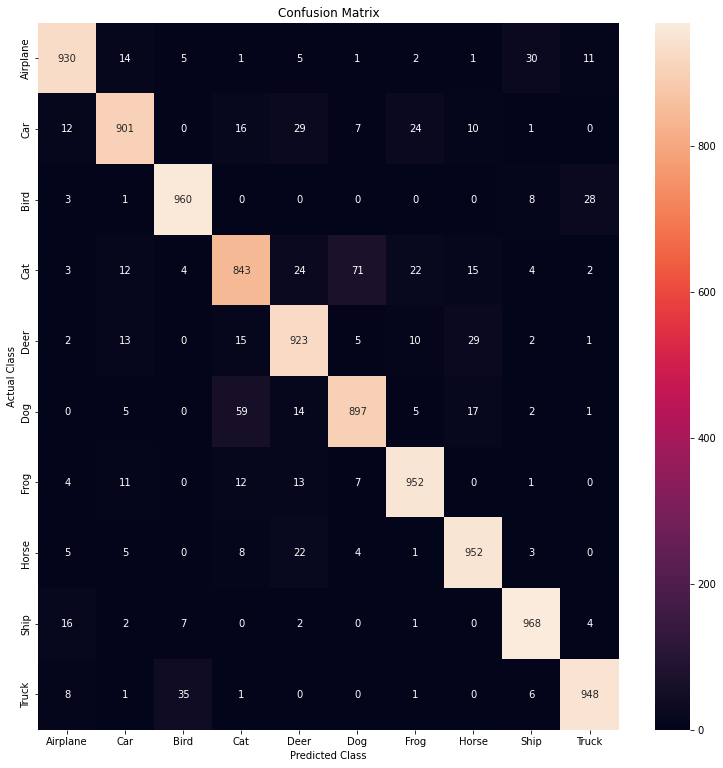

In [11]:
test_acc = model_eval(xtest, ytest, model, 'test')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


0
2000
4000
6000
8000
10000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 432x288 with 0 Axes>

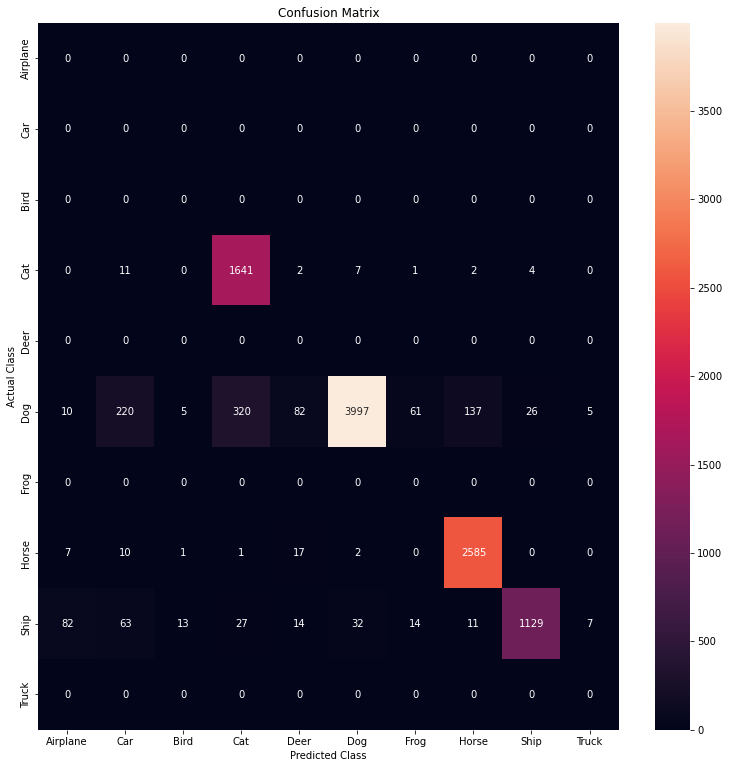

In [16]:
gen_acc = model_eval(xgen, ygen, model, 'gen')

In [17]:
gen_acc

0.8867817181869904

In [12]:
test_acc

0.9274